In [5]:
from gensim.models import Word2Vec
import multiprocessing

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import re
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

CPU


In [4]:
path = "./Text-mining-with-Simpsons-Data-master"
# from google.colab import drive
# drive.mount('/content/drive')

### 1. Импорт и предобработка данных

In [7]:
act_columns = ["raw_character_text", "spoken_words"]

data = pd.read_csv(os.path.join(path, 'simpsons_script_lines.csv'), usecols=act_columns)
data = data.dropna().reset_index(drop=True).drop_duplicates()
data

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
132105,Miss Hoover,I'm back.
132106,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
132107,Miss Hoover,Psy-cho-so-ma-tic.
132108,Ralph Wiggum,Does that mean you were crazy?


In [8]:
""" чистка текста от знаков препинания/ приведение книжнему регистру """

sentense_list = [re.sub(r"[-()\"#/@;:$!<>{}=~|.?,]", "", str(x)) for x in data['spoken_words']]
sentense_list = [x.lower() for x in sentense_list]

In [9]:
""" приведение текста реплик к формату списка слов """

sentense_corpus = [x.split() for x in sentense_list]
data['spoken_words_corp'] = sentense_corpus
data.head()

,raw_character_text,spoken_words,spoken_words_corp
0,Miss Hoover,"No, actually, it was a little of both. Sometim...","[no, actually, it, was, a, little, of, both, s..."
1,Lisa Simpson,Where's Mr. Bergstrom?,"[where's, mr, bergstrom]"
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,"[i, don't, know, although, i'd, sure, like, to..."
3,Lisa Simpson,That life is worth living.,"[that, life, is, worth, living]"
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,"[the, polls, will, be, open, from, now, until,..."


In [10]:
""" Классификатор реплик:  Барт / Лиза / Прочие """

data.loc[data.raw_character_text == 'Lisa Simpson', 'class_L_B']  = 1
data.loc[data.raw_character_text == 'Bart Simpson', 'class_L_B']  = 2
data['class_L_B'] = data['class_L_B'].fillna(0)
data['class_L_B'].value_counts()

class_L_B
0.0    104651
2.0     12088
1.0     10156
Name: count, dtype: int64

In [13]:
""" максимальная длина реплик ключевых персонажей """

data['data_len'] = [len(i) for i in data.spoken_words_corp]
data_pt = pd.pivot_table(
        data, 
        values = 'data_len', 
        index = 'raw_character_text', 
        aggfunc = 'max'
).reset_index()

data_pt[(data_pt.raw_character_text =='Lisa Simpson') | (data_pt.raw_character_text =='Bart Simpson')]


,raw_character_text,data_len
602,Bart Simpson,73
3315,Lisa Simpson,75


In [15]:
""" 
Если длина реплик ключевых персонажей не более 75 слов
ограничим на этом пороге исследование 
"""

data['spoken_words_corp'] = [i[:75] for i in data['spoken_words_corp']]
data.head(1)

,raw_character_text,spoken_words,spoken_words_corp,class_L_B,data_len
0,Miss Hoover,"No, actually, it was a little of both. Sometim...","[no, actually, it, was, a, little, of, both, s...",0.0,31


In [16]:
data.iloc[:,[-2,-3]].head()

,class_L_B,spoken_words_corp
0,0.0,"[no, actually, it, was, a, little, of, both, s..."
1,1.0,"[where's, mr, bergstrom]"
2,0.0,"[i, don't, know, although, i'd, sure, like, to..."
3,1.0,"[that, life, is, worth, living]"
4,0.0,"[the, polls, will, be, open, from, now, until,..."


In [21]:
sents = data.spoken_words_corp.tolist()
labels = data.class_L_B.values.tolist()

### 2. Обучение Word2Vec  /  Визуализация по топ - 1000 самых частотных слов

In [22]:
model = Word2Vec(sents, min_count=1)

In [25]:
word_freq = defaultdict(int)

for sent in sentense_corpus:
    for i in sent:
        word_freq[i] += 1
        
len(word_freq), word_freq

(46878,
 defaultdict(int,
             {'no': 7032,
              'actually': 466,
              'it': 13848,
              'was': 5481,
              'a': 31052,
              'little': 2531,
              'of': 16219,
              'both': 308,
              'sometimes': 172,
              'when': 2405,
              'disease': 38,
              'is': 12356,
              'in': 12636,
              'all': 6662,
              'the': 41852,
              'magazines': 25,
              'and': 19247,
              'news': 299,
              'shows': 114,
              "it's": 6594,
              'only': 1681,
              'natural': 75,
              'that': 12691,
              'you': 37029,
              'think': 2823,
              'have': 7491,
              "where's": 386,
              'mr': 1594,
              'bergstrom': 19,
              'i': 35576,
              "don't": 6816,
              'know': 4681,
              'although': 101,
              "i'd": 1103,
              

In [26]:
top_1000 = sorted(word_freq, key=word_freq.get, reverse=True)[:1000]

X = model.wv[top_1000]

pca = PCA(n_components=2)
res = pca.fit_transform(X)

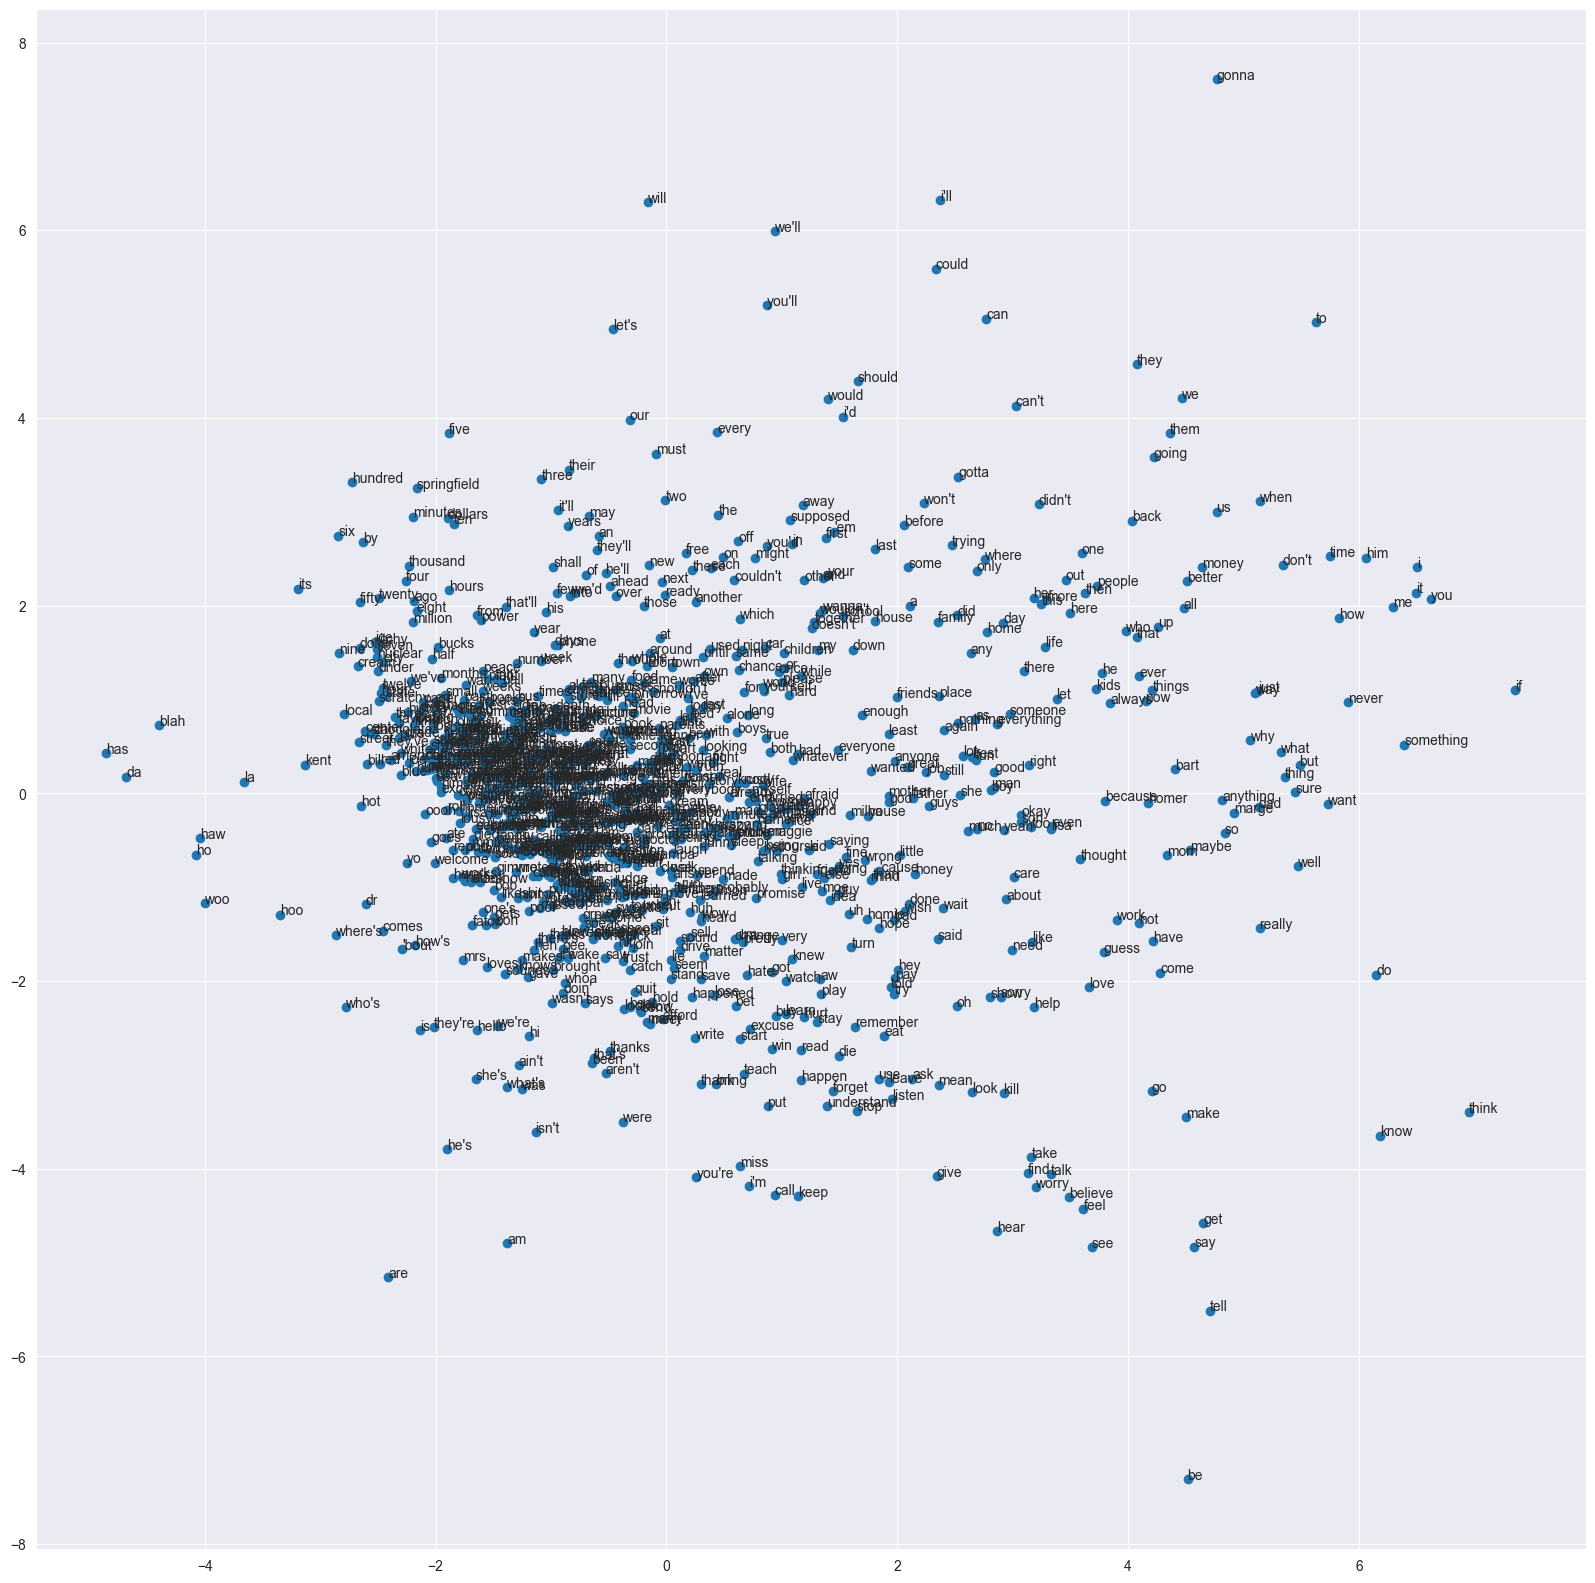

In [27]:
plt.scatter(res[:,0], res[:,1])

for i, word in enumerate(top_1000):
	  plt.annotate(word, xy=(res[i, 0], res[i, 1]))
   
plt.gcf().set_size_inches(20, 20)

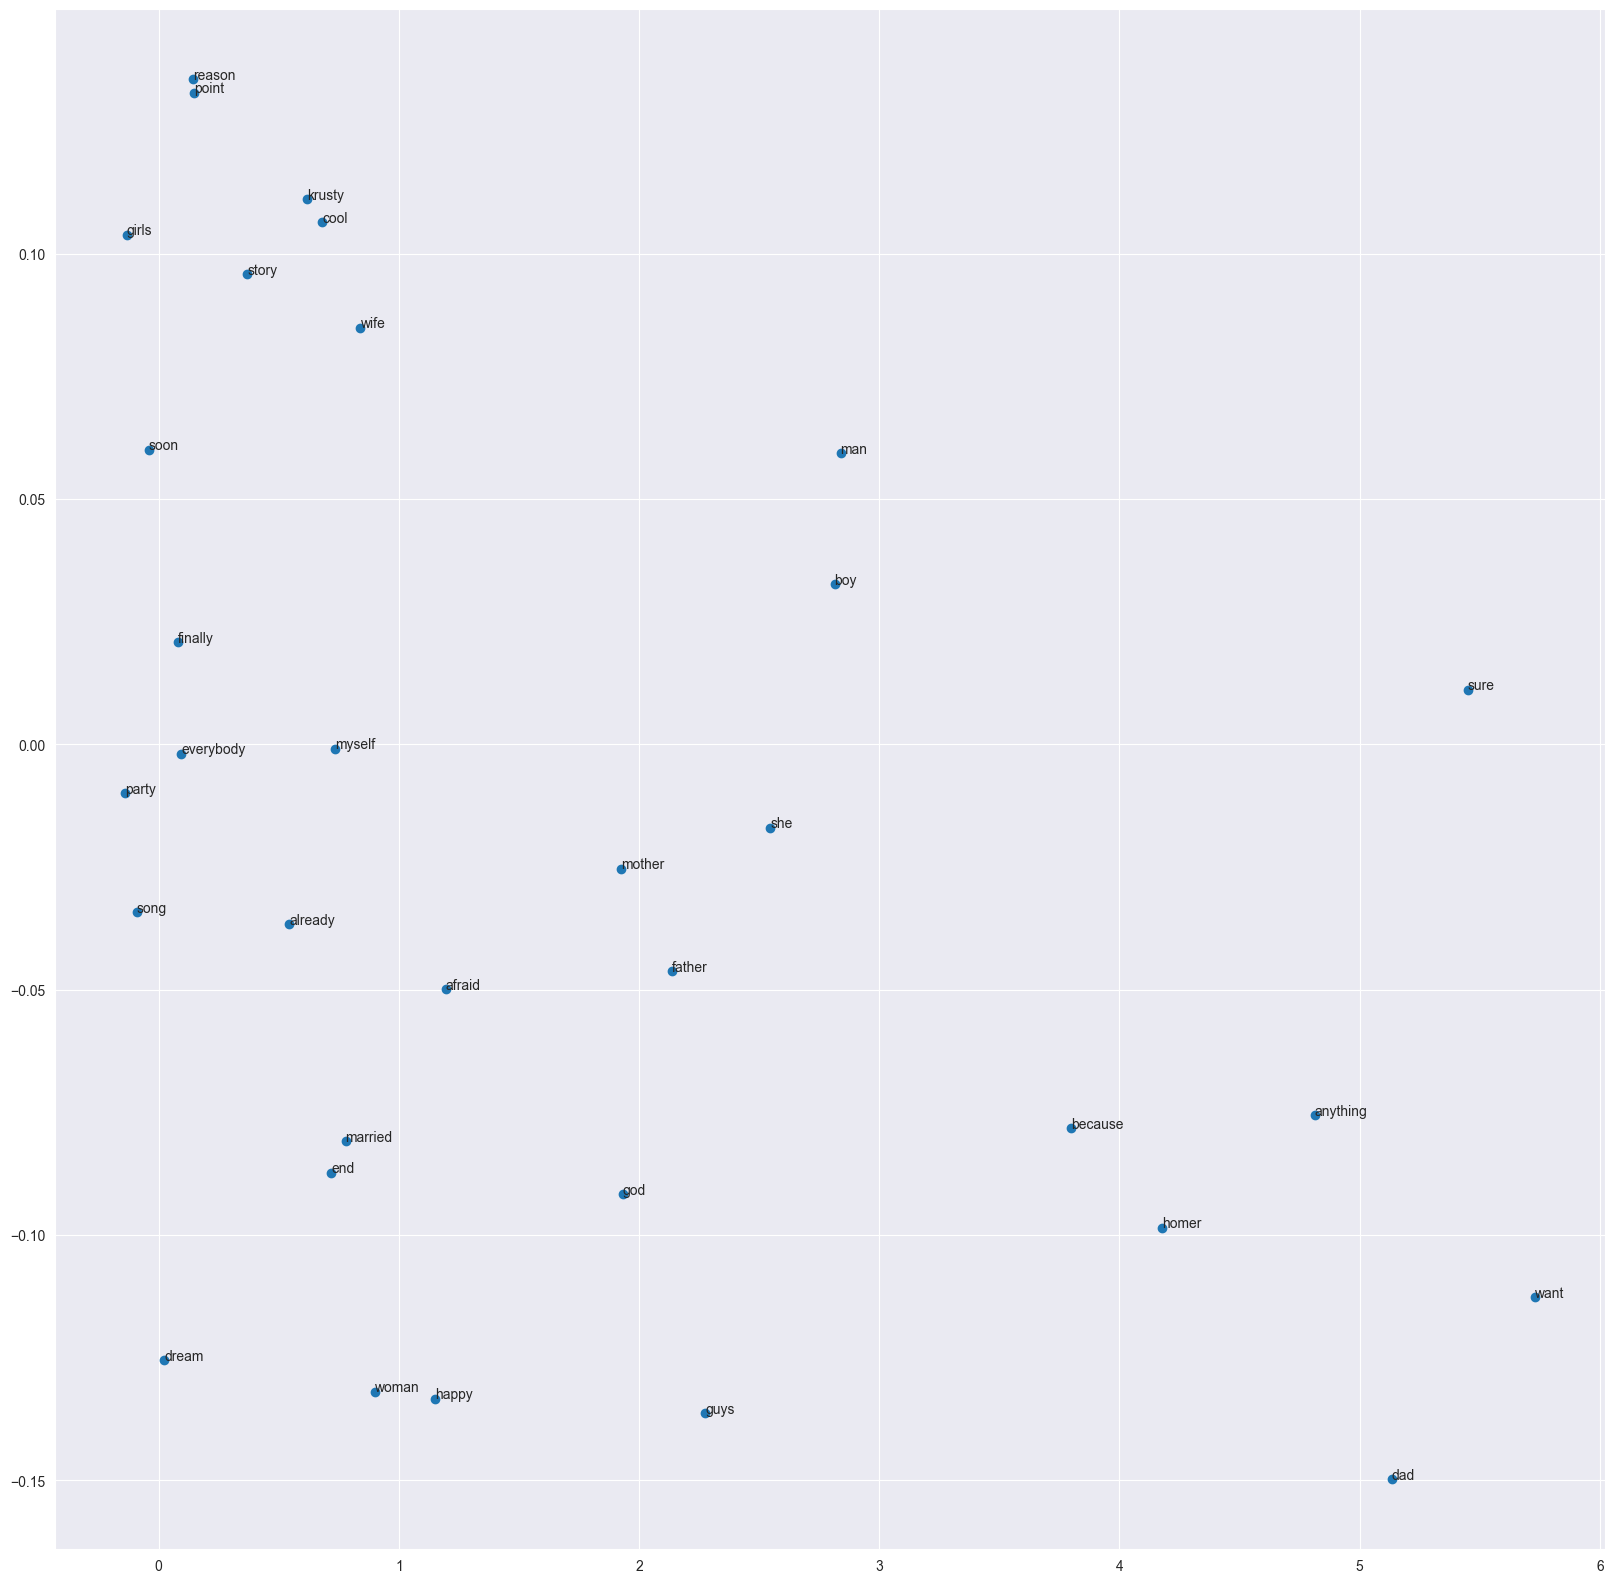

In [28]:
""" фокус по центру """

df_res = pd.DataFrame(res)
df_res['word'] = top_1000
min_, max_ = -0.15, 0.15
df_res_short = df_res[(df_res[0] > min_)&(df_res[1] > min_) & (df_res[1] < max_)&(df_res[1] < max_)]

plt.scatter(df_res_short[0], df_res_short[1])

for i in range(len(df_res_short)):
    string = df_res_short.iloc[i,:]
    plt.annotate(string['word'], xy=(string[0], string[1]))
    
plt.gcf().set_size_inches(20, 20)

### 3. Найти самые близкие слова для: 
- homer - marge + bart 
- bart - lisa + school 
- marge - homer + home

In [29]:
model.wv.most_similar(positive=["homer", "bart"], negative=["marge"], topn=5)

[('lisa', 0.8494237661361694),
 ('grampa', 0.7143591046333313),
 ('milhouse', 0.7083521485328674),
 ('son', 0.6875342726707458),
 ('maggie', 0.6732863783836365)]

In [30]:
model.wv.most_similar(positive=["bart", "school"], negative=["lisa"], topn=5)

[('house', 0.7733992338180542),
 ('game', 0.770982027053833),
 ('church', 0.7521446347236633),
 ('store', 0.7489696145057678),
 ('town', 0.7464414834976196)]

In [31]:
model.wv.most_similar(positive=["marge", "home"], negative=["homer"], topn=5)

[('back', 0.7886782884597778),
 ('bed', 0.6899083852767944),
 ('sleep', 0.6875349879264832),
 ('here', 0.6678440570831299),
 ('together', 0.6396388411521912)]

In [32]:
model.wv.similarity("lisa", 'bart')

0.9438708

### 4. Построить и обучить классификатор  реплик Bart / Lisa

In [33]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,raw_character_text,spoken_words,spoken_words_corp,class_L_B,data_len
0,Executive,"All right, kids, we learned a lot today. Now, ...","[all, right, kids, we, learned, a, lot, today,...",0.0,22
1,Nelson Muntz,Save it for the warden.,"[save, it, for, the, warden]",0.0,5
2,Groundskeeper Willie,"What are ya lookin' at, ya bastards?!","[what, are, ya, lookin', at, ya, bastards]",0.0,7
3,Chief Wiggum,"Alright, get the scent, boy. Come on. Get the ...","[alright, get, the, scent, boy, come, on, get,...",0.0,14
4,The Vamp,ANY MINUTE NOW / HE'LL SCAMPER THROUGH THAT DO...,"[any, minute, now, he'll, scamper, through, th...",0.0,9


In [34]:
sents = data.spoken_words_corp.tolist()
y = data.class_L_B.values.tolist()

In [35]:
batch_size = 2000
sent_size  = 75
vec_size   = model.wv.get_vector('do').shape[0]
n_classes = len(set(y))

In [36]:
train = []
for i0, sent in enumerate(sents[:100000]):
    X = torch.zeros(sent_size, vec_size)
    
    for i1, word in enumerate(sent):
        r = torch.tensor(model.wv[word])
        X[i1] = r
        
    train.append((X.T, y[i0]))

test = []
for i0, sent in enumerate(sents[100000:]):
    X = torch.zeros(sent_size, vec_size)
    
    for i1, word in enumerate(sent):
        r = torch.tensor(model.wv[word])
        X[i1] = r
        
    test.append((X.T, y[i0 + 100000]))

In [39]:
data_train = DataLoader(train, batch_size = batch_size, shuffle=True)
data_test =  DataLoader(test, batch_size = batch_size, shuffle=True)

In [48]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm3 = nn.BatchNorm1d(32)
        self.norm2 = nn.BatchNorm1d(128)
        self.norm1 = nn.BatchNorm1d(512)
        self.l1 = nn.Linear(7500, 512)
        self.l2 = nn.Linear(512, 128)
        self.l3 = nn.Linear(128, 32)
        self.l4 = nn.Linear(32, 3)
        self.drop = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, input):
        x = input
        x = self.flat(x)
        
        for i in range(1, 5):
            x = self._modules[f"l{i}"](x)
            
            if (i == 4):
                break
            
            x = self.relu(x)
            x = self.drop(x)
            x = self._modules[f"norm{i}"](x)

        return x

In [49]:
model1 = Net1().to(device)

In [51]:
optim = torch.optim.Adam(model1.parameters(), lr=0.00005)
crit  = torch.nn.CrossEntropyLoss()
n_iters = 30

for iter in range(n_iters):
    model1.train()
    for X, y in data_train:
        X, y = X.to(device), y.type(torch.LongTensor).to(device)        
        optim.zero_grad()
        pred = model1(X)
        loss = crit(pred, y)
        loss.backward()
        optim.step()
    train_score = torch.sum(torch.argmax(pred, axis=1) == y).item() / y.shape[0]

    model1.eval()
    for X, y in data_test:
        X, y = X.to(device), y.type(torch.LongTensor).to(device)
        pred = model1(X)
        test_score = torch.sum(torch.argmax(pred, axis=1) == y).item() / y.shape[0]
        print(f'iter {iter}, loss = {loss}, train score = {train_score}, test score = {test_score}')
        break

iter 0, loss = 1.106316089630127, train score = 0.4295, test score = 0.562
iter 1, loss = 1.0603578090667725, train score = 0.467, test score = 0.582
iter 2, loss = 1.039523959159851, train score = 0.5015, test score = 0.6385
iter 3, loss = 1.01948881149292, train score = 0.5255, test score = 0.664
iter 4, loss = 1.0039814710617065, train score = 0.5565, test score = 0.6585
iter 5, loss = 0.9800269603729248, train score = 0.595, test score = 0.708
iter 6, loss = 0.9756745100021362, train score = 0.6185, test score = 0.7275
iter 7, loss = 0.9406779408454895, train score = 0.6575, test score = 0.7555
iter 8, loss = 0.9271158576011658, train score = 0.6815, test score = 0.7675
iter 9, loss = 0.8919291496276855, train score = 0.7055, test score = 0.7525
iter 10, loss = 0.8571291565895081, train score = 0.7395, test score = 0.7585
iter 11, loss = 0.8627095818519592, train score = 0.75, test score = 0.775
iter 12, loss = 0.7974823117256165, train score = 0.7825, test score = 0.7855
iter 13, 